In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify
%cd '../'
!pwd

/cephyr/users/markpett/Alvis/satellite_poverty_prediction
/cephyr/users/markpett/Alvis/satellite_poverty_prediction


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from utils.plot import scatter_preds

Read data

In [3]:
df = pd.read_csv('/cephyr/NOBACKUP/groups/globalpoverty1/data/map_predictions.csv')
df = df.drop(['system:index', '.geo'], axis=1)
df = df.loc[~(df==0).any(axis=1)]

# Remove some small territories
remove_countries = ['Spain (Canary Is)', 'Spain (Africa)', 'Halaib Triangle', 'Abyei Area', 'Koualou Area', 'South Sudan']

df = df[~df['country_na'].isin(remove_countries)]
df.head()

,country_co,country_na,iwi_2000,iwi_2001,iwi_2002,iwi_2003,iwi_2004,iwi_2005,iwi_2006,iwi_2007,...,pop_2010,pop_2011,pop_2012,pop_2013,pop_2014,pop_2015,pop_2016,pop_2017,pop_2018,pop_2019
0,CD,Chad,11048.352476,11976.686922,13445.286372,14233.337986,14616.692523,16000.593438,16961.081503,17166.512312,...,392886.175501,407435.389418,422756.323625,438601.205870,455067.471493,472268.706312,490181.292804,508939.065175,528313.915400,548622.031313
1,MI,Malawi,57387.585717,58915.961513,62697.792094,64359.641898,66138.093188,70655.705756,72706.832443,74815.198674,...,474614.675015,488335.785760,502314.401165,516889.510145,531640.145707,547406.319395,564074.072181,581024.094175,598950.909437,617687.326929
2,ZA,Zambia,46303.186901,48180.557667,52494.441587,55035.959199,57228.355864,61988.141962,65125.641033,67358.599110,...,451140.675870,466204.933384,482176.527523,498963.591104,516483.882543,535001.032191,554606.967303,575295.845255,597229.072829,620393.624430
3,ZI,Zimbabwe,67264.223169,68389.689248,72563.516419,73417.012830,74178.785075,77103.340446,77884.072248,78587.530484,...,439224.126930,444483.586232,449728.966350,455024.524842,460361.587102,465865.588192,471468.511058,477039.485032,482848.266994,488648.560492
4,BC,Botswana,8332.666408,8707.814125,9622.602262,10220.608006,10409.532670,11374.736129,11604.062223,12043.336198,...,68398.333717,69724.411918,71077.359475,72444.895482,73841.805930,75282.685335,76719.529494,78205.058312,79733.534220,81305.484192


Add ISO country codes

In [4]:
cc_df = pd.read_csv('https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv')

# Retain ISO and FIPS country codes
cc_df = cc_df[['ISO3166-1-Alpha-3', 'FIPS']]
cc_df.columns = ['ccode', 'FIPS']

# Swap FIPS for ISO
df = pd.merge(cc_df.rename(columns={'ccode': 'iso_a3'}), df.rename(columns={'country_co': 'FIPS'}), on=['FIPS'])
df.head()

,iso_a3,FIPS,country_na,iwi_2000,iwi_2001,iwi_2002,iwi_2003,iwi_2004,iwi_2005,iwi_2006,...,pop_2010,pop_2011,pop_2012,pop_2013,pop_2014,pop_2015,pop_2016,pop_2017,pop_2018,pop_2019
0,DZA,AG,Algeria,346458.822968,353966.073915,384064.980765,390162.999888,397808.782698,426854.701690,434224.732920,...,1.214081e+06,1.237586e+06,1.261532e+06,1.287457e+06,1.314738e+06,1.343918e+06,1.374110e+06,1.406323e+06,1.440747e+06,1.477456e+06
1,AGO,AO,Angola,57292.639610,59884.801047,65562.449149,68041.435563,70126.933098,80990.721563,87087.028820,...,7.234067e+05,7.439698e+05,7.694806e+05,8.003507e+05,8.372869e+05,8.814346e+05,9.337387e+05,9.950516e+05,1.067417e+06,1.151867e+06
2,BEN,BN,Benin,42248.826378,44006.027066,49595.920923,50676.135227,52834.515078,57856.763386,59515.866100,...,3.075163e+05,3.188905e+05,3.308147e+05,3.432866e+05,3.562920e+05,3.698621e+05,3.841018e+05,3.989709e+05,4.145469e+05,4.308767e+05
3,BWA,BC,Botswana,8332.666408,8707.814125,9622.602262,10220.608006,10409.532670,11374.736129,11604.062223,...,6.839833e+04,6.972441e+04,7.107736e+04,7.244490e+04,7.384181e+04,7.528269e+04,7.671953e+04,7.820506e+04,7.973353e+04,8.130548e+04
4,BFA,UV,Burkina Faso,50301.514358,52578.946054,57321.737641,59555.783621,62154.692664,68794.349546,71849.756815,...,5.495480e+05,5.684312e+05,5.881814e+05,6.089259e+05,6.306988e+05,6.533447e+05,6.771171e+05,7.021710e+05,7.283528e+05,7.558585e+05


Pivot to one row per country-year

In [5]:
c_vars = ['iso_a3', 'country_na']
iwi_cols = [f'iwi_{i}' for i in range(2000, 2020)]
pop_cols = [f'pop_{i}' for i in range(2000, 2020)]

# Get only IWI data
iwi_df = df[c_vars + iwi_cols]
# Drop 'iwi' from 'iwi_2000'
iwi_df = iwi_df.rename(columns={x: x[-4:] for x in iwi_cols})
iwi_df = iwi_df.melt(id_vars=c_vars, 
        var_name='year', 
        value_name='iwi')

# Get only population data
pop_df = df[c_vars + pop_cols]
# Drop 'pop' from 'pop_2000'
pop_df = pop_df.rename(columns={x: x[-4:] for x in pop_cols})
pop_df = pop_df.melt(id_vars=c_vars, 
        var_name='year', 
        value_name='pop')

# Merge IWI and population data
merge_cols = c_vars + ['year']
df = iwi_df.merge(pop_df, left_on=merge_cols, right_on=merge_cols)

# Make sure year is int
df = df.astype({'year': 'int32'})
df.head()

,iso_a3,country_na,year,iwi,pop
0,DZA,Algeria,2000,346458.822968,1.027493e+06
1,AGO,Angola,2000,57292.639610,6.957560e+05
2,BEN,Benin,2000,42248.826378,2.170075e+05
3,BWA,Botswana,2000,8332.666408,5.687215e+04
4,BFA,Burkina Faso,2000,50301.514358,3.991609e+05


In [6]:
df['iwi/pop'] = df['iwi'] / df['pop']
df.head()

,iso_a3,country_na,year,iwi,pop,iwi/pop
0,DZA,Algeria,2000,346458.822968,1.027493e+06,0.337189
1,AGO,Angola,2000,57292.639610,6.957560e+05,0.082346
2,BEN,Benin,2000,42248.826378,2.170075e+05,0.194688
3,BWA,Botswana,2000,8332.666408,5.687215e+04,0.146516
4,BFA,Burkina Faso,2000,50301.514358,3.991609e+05,0.126018


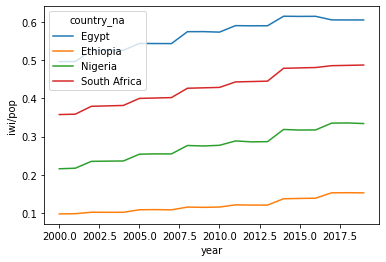

In [7]:
plot_countries = ['Egypt', 'Nigeria', 'Ethiopia', 'South Africa']
sns.lineplot(data=df[df['country_na'].isin(plot_countries)], x='year', y='iwi/pop', hue='country_na')
plt.show()

### Compare to QOG

In [8]:
qog_df = pd.read_csv('https://www.qogdata.pol.gu.se/data/qog_std_ts_jan22.csv')
qog_df = qog_df[(qog_df['year'] > 1989) & (qog_df['year'] < 2020)]
qog_df = qog_df.rename(columns={'ccodealp': 'iso_a3'})
qog_df = qog_df[qog_df['iso_a3'].isin(df['iso_a3'].unique())]
qog_df

/local/tmp.735450/ipykernel_2504141/3241703723.py:1: DtypeWarning: Columns (793,797,801,805,1268,1269) have mixed types. Specify dtype option on import or set low_memory=False.
  qog_df = pd.read_csv('https://www.qogdata.pol.gu.se/data/qog_std_ts_jan22.csv')


,ccode,cname,year,ccode_qog,cname_qog,iso_a3,ccodecow,version,cname_year,ccodealp_year,...,wwbi_rrespubpemp,wwbi_sprpempn,wwbi_sprpempp,wwbi_sprpemps,wwbi_sprpempt,wwbi_spupempn,wwbi_spupempp,wwbi_spupemps,wwbi_spupempt,wwbi_tertiarypubsec
196,12,Algeria,1990,12,Algeria,DZA,615.0,QoGStdTSjan22,Algeria 1990,DZA90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,12,Algeria,1991,12,Algeria,DZA,615.0,QoGStdTSjan22,Algeria 1991,DZA91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,12,Algeria,1992,12,Algeria,DZA,615.0,QoGStdTSjan22,Algeria 1992,DZA92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,12,Algeria,1993,12,Algeria,DZA,615.0,QoGStdTSjan22,Algeria 1993,DZA93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,12,Algeria,1994,12,Algeria,DZA,615.0,QoGStdTSjan22,Algeria 1994,DZA94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,894,Zambia,2015,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2015,ZMB15,...,0.226445,0.028817,0.172776,0.578589,0.219818,0.017781,0.109138,0.342219,0.530862,0.501821
14933,894,Zambia,2016,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2016,ZMB16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14934,894,Zambia,2017,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2017,ZMB17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14935,894,Zambia,2018,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2018,ZMB18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
qog_hdi_df = qog_df[['iso_a3', 'year', 'undp_hdi']]
hdi_df = df.merge(qog_hdi_df, left_on=['iso_a3', 'year'], right_on=['iso_a3', 'year'])
hdi_df

,iso_a3,country_na,year,iwi,pop,iwi/pop,undp_hdi
0,DZA,Algeria,2000,346458.822968,1.027493e+06,0.337189,0.637
1,AGO,Angola,2000,57292.639610,6.957560e+05,0.082346,0.400
2,BEN,Benin,2000,42248.826378,2.170075e+05,0.194688,0.416
3,BWA,Botswana,2000,8332.666408,5.687215e+04,0.146516,0.581
4,BFA,Burkina Faso,2000,50301.514358,3.991609e+05,0.126018,0.293
...,...,...,...,...,...,...,...
955,TUN,Tunisia,2019,200981.172655,3.971655e+05,0.506039,0.740
956,UGA,Uganda,2019,319320.527036,1.407275e+06,0.226907,0.544
957,TZA,Tanzania,2019,370762.017410,1.883094e+06,0.196890,0.529
958,ZMB,Zambia,2019,140241.382768,6.203936e+05,0.226052,0.584


In [10]:
clean_hdi_df = hdi_df.dropna()
scipy.stats.pearsonr(clean_hdi_df['iwi/pop'], clean_hdi_df['undp_hdi'])[0]

0.7376096576085152

<AxesSubplot:xlabel='iwi/pop', ylabel='undp_hdi'>

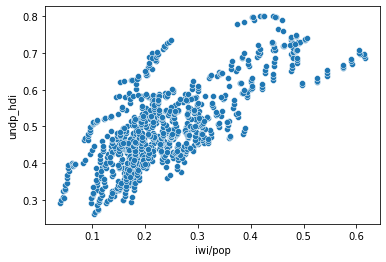

In [11]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] != 'Sudan'], x='iwi/pop', y='undp_hdi')

In [12]:
clean_hdi_df[(clean_hdi_df['undp_hdi'] < 0.65) & (clean_hdi_df['iwi/pop'] < 0.05)]

,iso_a3,country_na,year,iwi,pop,iwi/pop,undp_hdi
8,TCD,Chad,2000,11048.352476,274870.637402,0.040195,0.293
56,TCD,Chad,2001,11976.686922,284814.394000,0.042051,0.301
104,TCD,Chad,2002,13445.286372,295019.506467,0.045574,0.307
152,TCD,Chad,2003,14233.337986,305674.532988,0.046564,0.305
200,TCD,Chad,2004,14616.692523,316716.053763,0.046151,0.324
248,TCD,Chad,2005,16000.593438,328174.751685,0.048756,0.327
296,TCD,Chad,2006,16961.081503,340149.853672,0.049864,0.330
344,TCD,Chad,2007,17166.512312,352632.707009,0.048681,0.340


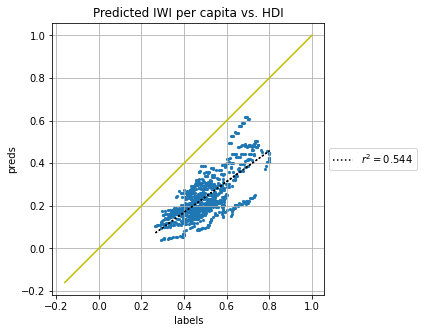

In [14]:
preds = clean_hdi_df[clean_hdi_df['iso_a3'] != 'SSD']['iwi/pop']
labels = clean_hdi_df[clean_hdi_df['iso_a3'] != 'SSD']['undp_hdi']

norm_preds = (preds - preds.min()) / (preds.max() - preds.min())
norm_labels = (labels - labels.min()) / (labels.max() - labels.min())

scatter_preds(labels, preds, by_name=None, by_col=None,
              title='Predicted IWI per capita vs. HDI')

/local/tmp.735450/ipykernel_2504141/844762945.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Mean satellite-predicted IWI'] *= 100


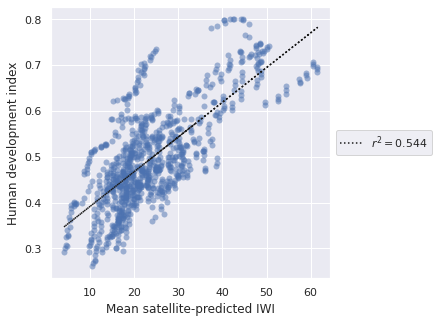

In [82]:
'''Creates a scatter plot of labels vs. preds, overlayed with regression line.

Args
- labels: np.array, shape [N]
- preds: np.array, shape [N]
- by_name: str, name of col
- by_col: np.array, shape [N]
- ax: matplotlib.axes.Axes
- figsize: tuple of (width, height)
'''

plot_df = clean_hdi_df[['iwi/pop', 'undp_hdi', 'iso_a3']]
plot_df.columns = ['Mean satellite-predicted IWI', 'Human development index', 'country']

plot_df['Mean satellite-predicted IWI'] *= 100

#data = {'HDI': labels, 'Mean predicted IWI': preds}
# df = pd.DataFrame(data)
preds = plot_df['Mean satellite-predicted IWI']
labels = plot_df['Human development index']

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# y=x
#lo, hi = min(min(labels), min(preds)) - 0.2, max(max(labels), max(preds)) + 0.2
#ax.plot([lo, hi], [lo, hi], '-y')

# scatterplot
sns.scatterplot(data=plot_df, y='Human development index', x='Mean satellite-predicted IWI', ax=ax, alpha=0.5,
                linewidth=0, legend=False, palette="muted", ci=None)

# regression line
r2 = scipy.stats.pearsonr(preds, labels)[0] ** 2
m, b = np.polyfit(preds, labels, 1)
ax.plot(preds, m * preds + b, ':k', label=f'$r^2={r2:.3g}$')

# ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

# ax.set_title('title')
plt.savefig('mean_iwi_vs_HDI.png', bbox_inches='tight')
plt.show()

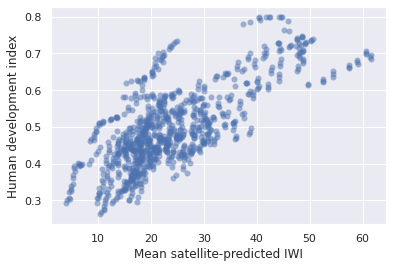

In [81]:
sns.scatterplot(data=plot_df, y='Human development index', x='Mean satellite-predicted IWI', alpha=0.5,
                linewidth=0, legend=False, palette="muted", ci=None)
plt.show()

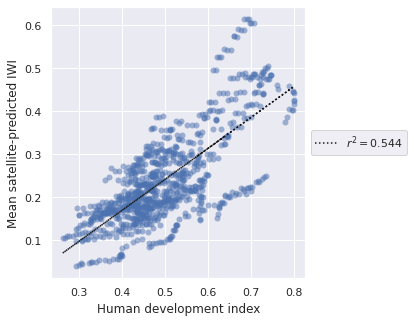

In [74]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# y=x
#lo, hi = min(min(labels), min(preds)) - 0.2, max(max(labels), max(preds)) + 0.2
#ax.plot([lo, hi], [lo, hi], '-y')

# scatterplot
sns.scatterplot(data=plot_df, x='Human development index', y='Mean satellite-predicted IWI', ax=ax, alpha=0.5,
                linewidth=0, legend=False, palette="muted", ci=None)

# regression line
r2 = scipy.stats.pearsonr(preds, labels)[0] ** 2
m, b = np.polyfit(labels, preds, 1)
ax.plot(labels, m * labels + b, ':k', label=f'$r^2={r2:.3g}$')

ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

# ax.set_title('title')
plt.show()

In [49]:
plot_df.sort_values('Mean predicted IWI')

,Mean predicted IWI,HDI,country
8,0.040195,0.293,TCD
56,0.042051,0.301,TCD
104,0.045574,0.307,TCD
200,0.046151,0.324,TCD
152,0.046564,0.305,TCD
...,...,...,...
925,0.605638,0.707,EGY
829,0.605783,0.698,EGY
733,0.614955,0.691,EGY
781,0.615145,0.696,EGY


In [25]:
scipy.stats.spearmanr(preds, labels)[0] ** 2

0.46689361088490816

In [14]:
scipy.stats.pearsonr(clean_hdi_df['iwi/pop'], clean_hdi_df['undp_hdi'])[0] ** 2

0.5440680069973509

In [15]:
scipy.stats.pearsonr(clean_hdi_df['year'], clean_hdi_df['undp_hdi'])[0] ** 2

0.11416225254102624

In [16]:
clean_hdi_df.groupby('country_na').apply(lambda x: scipy.stats.pearsonr(x['iwi/pop'], x['undp_hdi'])[0])

country_na
Algeria                 0.969972
Angola                  0.957982
Benin                   0.980544
Botswana                0.973408
Burkina Faso            0.970727
Burundi                 0.782831
Cameroon                0.983639
Central African Rep     0.949815
Chad                    0.925012
Cote d'Ivoire           0.979942
Dem Rep of the Congo    0.940866
Djibouti                0.943150
Egypt                   0.965811
Equatorial Guinea       0.831584
Eritrea                 0.829257
Ethiopia                0.915808
Gabon                   0.913784
Gambia, The             0.958910
Ghana                   0.979350
Guinea                  0.954058
Guinea-Bissau           0.959310
Kenya                   0.947547
Lesotho                 0.933542
Liberia                 0.924387
Libya                  -0.735291
Madagascar              0.893516
Malawi                  0.922908
Mali                    0.934238
Mauritania              0.981373
Morocco                 0.988340

In [22]:
clean_hdi_df.groupby('country_na').apply(lambda x: scipy.stats.pearsonr(x['year'], x['undp_hdi'])[0])

country_na
Algeria                 0.974478
Angola                  0.987199
Benin                   0.993331
Botswana                0.988650
Burkina Faso            0.996445
Burundi                 0.950396
Cameroon                0.992216
Central African Rep     0.973845
Chad                    0.966400
Cote d'Ivoire           0.987474
Dem Rep of the Congo    0.992857
Djibouti                0.997534
Egypt                   0.995670
Equatorial Guinea       0.854871
Eritrea                 0.955535
Ethiopia                0.985234
Gabon                   0.979649
Gambia, The             0.985246
Ghana                   0.988344
Guinea                  0.992253
Guinea-Bissau           0.992231
Kenya                   0.989413
Lesotho                 0.894001
Liberia                 0.933629
Libya                  -0.783022
Madagascar              0.967643
Malawi                  0.942735
Mali                    0.960548
Mauritania              0.991645
Morocco                 0.998496

<AxesSubplot:xlabel='iwi/pop', ylabel='undp_hdi'>

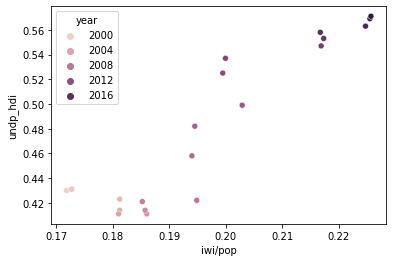

In [26]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] == 'Zimbabwe'], x='iwi/pop', y='undp_hdi', hue='year')

<AxesSubplot:xlabel='year', ylabel='iwi/pop'>

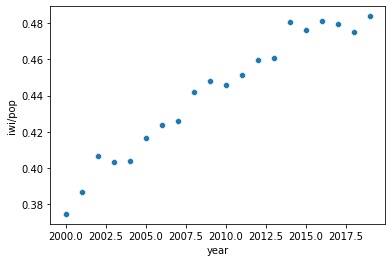

In [29]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] == 'Libya'], x='year', y='iwi/pop')

<AxesSubplot:xlabel='year', ylabel='undp_hdi'>

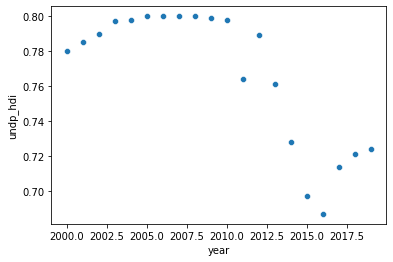

In [28]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] == 'Libya'], x='year', y='undp_hdi')

<AxesSubplot:xlabel='year', ylabel='undp_hdi'>

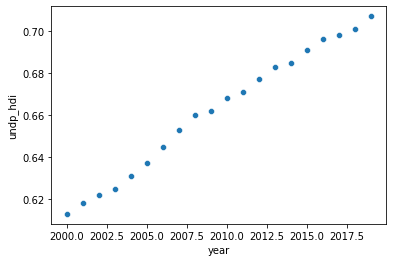

In [24]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] == 'Egypt'], x='year', y='undp_hdi')

<AxesSubplot:xlabel='iwi/pop', ylabel='undp_hdi'>

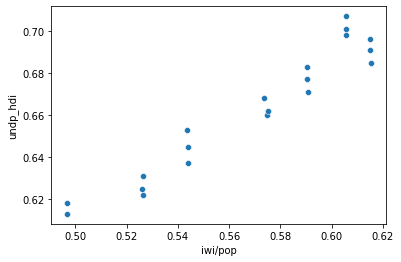

In [25]:
sns.scatterplot(data=clean_hdi_df[clean_hdi_df['country_na'] == 'Egypt'], x='iwi/pop', y='undp_hdi')